In [96]:
## Objectif : prédire le sentiment (positif, négatif, neutre) de tweets concernant Apple et Google.

In [120]:
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.metrics import recall_score
import numpy as np
from sklearn.metrics import classification_report

In [98]:
df = pd.read_csv('tweet_product_company.csv', encoding='latin-1', low_memory=False)
df.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [99]:
df.columns
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Création de variables utiles

In [100]:
TEXT = 'tweet_text'
LABEL_RAW = 'is_there_an_emotion_directed_at_a_brand_or_product'
TARGET = 'sentiment'

df = df[[TEXT, LABEL_RAW]].dropna().copy()
df[TARGET] = df[LABEL_RAW].str.lower().map({
    'positive emotion':'positive',
    'negative emotion':'negative',
    'no emotion toward brand or product':'neutral',
    'i can\'t tell':'neutral'
})
df = df.dropna(subset=[TARGET])
df[[TEXT, TARGET]].head()

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,positive
3,@sxsw I hope this year's festival isn't as cra...,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive


## Nettoyage 

In [101]:
import re

def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)     # urls
    s = re.sub(r"@\w+", " ", s)                 # mentions
    s = re.sub(r"#", " ", s)                    # hashtags symbol
    s = re.sub(r"[^a-z0-9']", " ", s)           # garder les lettres/ leschiffres/apostrophe
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s

df['text_clean'] = df[TEXT].astype(str).map(clean_text)
df = df[df['text_clean'].str.len() > 2]
df[TARGET].value_counts()

sentiment
neutral     5543
positive    2978
negative     570
Name: count, dtype: int64

In [74]:
df_bin = df[df[TARGET].isin(['positive','negative'])].copy()
df_bin[TARGET].value_counts(normalize=True)

sentiment
positive    0.839346
negative    0.160654
Name: proportion, dtype: float64

Split + Logistic Regression ....


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    df_bin['text_clean'], df_bin[TARGET], test_size=0.2, random_state=42, stratify=df_bin[TARGET]
)

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=3, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=200))
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

    negative       0.92      0.10      0.17       114
    positive       0.85      1.00      0.92       596

    accuracy                           0.85       710
   macro avg       0.88      0.55      0.55       710
weighted avg       0.86      0.85      0.80       710

[[ 11 103]
 [  1 595]]


In [103]:
df_multi = df.copy()
X_train, X_test, y_train, y_test = train_test_split(
    df_multi['text_clean'], df_multi[TARGET], test_size=0.2, random_state=42, stratify=df_multi[TARGET]
)

pipe_mc = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=3, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=300, multi_class='auto'))
])

pipe_mc.fit(X_train, y_train)
pred_mc = pipe_mc.predict(X_test)
print(classification_report(y_test, pred_mc))
print(confusion_matrix(y_test, pred_mc))

C:\Users\ESIH_ENERGIR\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.73      0.10      0.17       114
     neutral       0.71      0.89      0.79      1109
    positive       0.64      0.45      0.53       596

    accuracy                           0.69      1819
   macro avg       0.70      0.48      0.50      1819
weighted avg       0.69      0.69      0.67      1819

[[ 11  75  28]
 [  3 985 121]
 [  1 327 268]]


In [77]:
pipe_bal = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=3, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=300, class_weight='balanced'))
])
pipe_bal.fit(X_train, y_train)
pred_bal = pipe_bal.predict(X_test)
print(classification_report(y_test, pred_bal))


              precision    recall  f1-score   support

    negative       0.35      0.61      0.45       114
     neutral       0.78      0.71      0.74      1109
    positive       0.59      0.62      0.60       596

    accuracy                           0.67      1819
   macro avg       0.58      0.64      0.60      1819
weighted avg       0.69      0.67      0.68      1819



In [105]:
from sklearn.svm import LinearSVC
pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=3, ngram_range=(1,2))),
    ('clf', LinearSVC())
])
pipe_svm.fit(X_train, y_train)
pred_svm = pipe_svm.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

    negative       0.66      0.48      0.56       114
    positive       0.91      0.95      0.93       596

    accuracy                           0.88       710
   macro avg       0.78      0.72      0.74       710
weighted avg       0.87      0.88      0.87       710



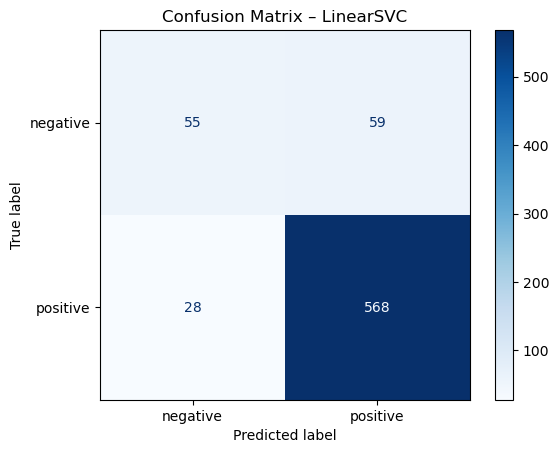

In [123]:
ConfusionMatrixDisplay.from_estimator(pipe_svm, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix – LinearSVC')
plt.savefig('reports/figures/confusion_matrix_linearSVC.png', dpi=300, bbox_inches='tight')
plt.show()

In [122]:
## LinearSVC avec pondération

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

pipe_svm_bal = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=3, ngram_range=(1,2))),
    ('clf', LinearSVC(class_weight='balanced', C=1.0))
])
pipe_svm_bal.fit(X_train, y_train)
pred = pipe_svm_bal.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.47      0.49      0.48       114
     neutral       0.75      0.76      0.75      1109
    positive       0.58      0.57      0.57       596

    accuracy                           0.68      1819
   macro avg       0.60      0.60      0.60      1819
weighted avg       0.68      0.68      0.68      1819



In [82]:
## Petit grid search

In [107]:
grid = {
    'tfidf__min_df':[2,3,5],
    'tfidf__ngram_range':[(1,1),(1,2)],
    'tfidf__max_features':[None, 30000, 60000],
    'clf__C':[0.5,1,2]
}
gs = GridSearchCV(
    Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LinearSVC(class_weight='balanced'))
    ]),
    grid, scoring='f1_macro', cv=3, n_jobs=-1
)
gs.fit(X_train, y_train)
best = gs.best_estimator_
print(gs.best_params_)
print(classification_report(y_test, best.predict(X_test)))

{'clf__C': 2, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

    negative       0.57      0.64      0.60       114
    positive       0.93      0.91      0.92       596

    accuracy                           0.86       710
   macro avg       0.75      0.77      0.76       710
weighted avg       0.87      0.86      0.87       710



In [84]:
## Interprétation rapide

In [108]:
import numpy as np
tfidf = best.named_steps['tfidf']
clf   = best.named_steps['clf']
feat  = np.array(tfidf.get_feature_names_out())

for cls_idx, cls in enumerate(clf.classes_):
    top = np.argsort(clf.coef_[cls_idx])[-15:]
    print(f'\nTop terms → {cls}:')
    print(feat[top][::-1])


Top terms → negative:
['link' 'cool' 'winning' 'great' 'ipad quot' 'at' 'party' 'fun' 'our'
 'awesome' 'of apple' 'free' 'smart' 'start' 'making']


IndexError: index 1 is out of bounds for axis 0 with size 1

In [86]:
joblib.dump(best, 'model_linearSVC.joblib')

['model_linearSVC.joblib']

In [ ]:
from pathlib import Path
out = Path('reports/figures')
out.mkdir(parents=True, exist_ok=True)
print("✅ Dossier créé :", out.resolve())


In [ ]:
model = globals().get('best', None) or globals().get('pipe_svm')

In [89]:
## Matrice de confusion normalisée

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', normalize='true')
plt.title('Confusion Matrix – Normalized')
plt.savefig(out/'confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

In [91]:
## Rappel par classe calculé automatiquement

In [ ]:
classes = sorted(set(y_test))
recalls = recall_score(y_test, model.predict(X_test), labels=classes, average=None)

plt.figure(figsize=(6,4))
plt.bar(classes, recalls)
plt.ylim(0,1); plt.ylabel('Recall'); plt.title('Recall per Class')
plt.savefig(out/'recall_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

In [93]:
## Top termes par classe

In [94]:
tfidf = model.named_steps['tfidf']
clf   = model.named_steps['clf']
feat  = np.array(tfidf.get_feature_names_out())

lines = []
for i, cls in enumerate(clf.classes_):
    top_idx = np.argsort(clf.coef_[i])[-15:]
    terms = feat[top_idx][::-1]
    lines.append(f"{cls}: {', '.join(terms)}")

(out/'top_terms.txt').write_text("\n".join(lines), encoding='utf-8')

399

In [109]:
print((out/'confusion_matrix_normalized.png').exists(),
      (out/'recall_per_class.png').exists(),
      (out/'top_terms.txt').exists())

True True True


## Traçabilité et versions

In [110]:
import sys, sklearn, pandas as pd, numpy as np
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)

Python: 3.12.7
pandas: 2.3.2
numpy: 1.26.4
scikit-learn: 1.7.1


## Graphique de distribution des classes

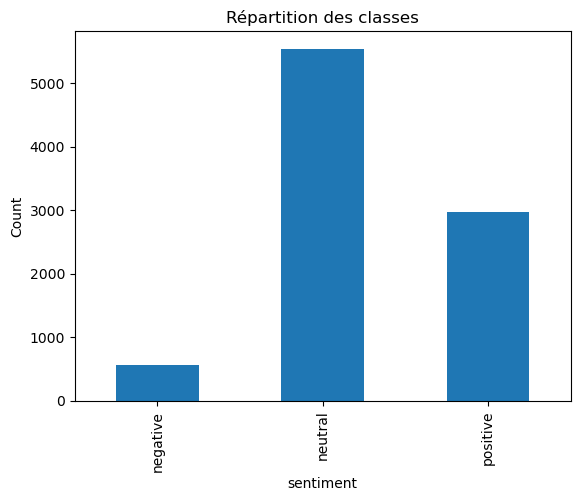

In [111]:
ax = df[TARGET].value_counts().reindex(['negative','neutral','positive']).plot.bar()
ax.set_ylabel("Count"); ax.set_title("Répartition des classes")
plt.show()

## Sauvegarde des données nettoyées

In [112]:
df[['text_clean', TARGET]].to_csv('tweets_clean.csv', index=False)

## Fonction de prédiction unitaire

In [113]:
def predict_tweet(txt, model=best):
    import re
    def clean(s):
        s = s.lower()
        s = re.sub(r"http\S+|www\.\S+", " ", s)
        s = re.sub(r"@\w+", " ", s)
        s = re.sub(r"#", " ", s)
        s = re.sub(r"[^a-z0-9']", " ", s)
        s = re.sub(r"\s{2,}", " ", s).strip()
        return s
    x = [clean(str(txt))]
    return model.predict(x)[0]

# exemple
predict_tweet("I love my new iPhone but the battery sucks")

'positive'

## Sauvegarde du modèle et résumé métriques

In [116]:
rep = classification_report(y_test, best.predict(X_test), output_dict=True)
import json, pathlib
pathlib.Path("reports").mkdir(exist_ok=True)
with open("reports/metrics.json","w") as f:
    json.dump(rep, f, indent=2)

In [118]:
SEED = 42
import numpy as np, random
np.random.seed(SEED); random.seed(SEED)